# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 1

> *Modelo de Regresión para predecir el Índice de Rendimiento Académico.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Importar desde Google Drive
!pip install -q gdown

In [2]:
# Datasets
import gdown
import zipfile

# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualizaciones
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye las siguientes variables para cada estudiante:

* **Hours Studied**: El número total de horas dedicadas al estudio por cada estudiante.
* **Previous Scores**: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* **Extracurricular Activities**: Si el estudiante participa en actividades extracurriculares (Sí o No).
* **Sleep Hours**: El número promedio de horas de sueño que el estudiante tuvo por día.
* **Sample Question Papers Practiced**: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:
* **Performance Index**: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.

### Descarga

In [4]:
# TP1-1-student_performance.zip
gdown.download('https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc')

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 39.7MB/s]


'TP1-1-student_performance.zip'

### Descompresión

In [5]:
with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-1')

### Carga

In [6]:
# Cargamos el dataset
df = pd.read_csv("TP1-1/Student_Performance.csv")
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


## Análisis Exploratorio

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [8]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [9]:
cols = df.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", df[col].isnull().sum())
    print("Cantidad de valores únicos: ", df[col].nunique())
    print("Tipo de dato: ", df[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if df[col].dtype == "object":
        print("--------------------\n")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if df[col].nunique() < 10:
        print("Valores únicos: ", df[col].unique())
        print("Cantidad de veces que aparece cada valor: ", df[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", df[col].mean())
        print("Desvío estándar: ", df[col].std())
        print("Mínimo: ", df[col].min())
        print("Máximo: ", df[col].max())
    print("--------------------\n")

--------------------
Columna:  Hours Studied
Cantidad de valores nulos:  0
Cantidad de valores únicos:  9
Tipo de dato:  int64
Valores únicos:  [7 4 8 5 3 6 2 1 9]
Cantidad de veces que aparece cada valor:  Hours Studied
1    1152
6    1133
7    1129
3    1119
9    1115
5    1094
8    1088
4    1085
2    1085
Name: count, dtype: int64
--------------------

--------------------
Columna:  Previous Scores
Cantidad de valores nulos:  0
Cantidad de valores únicos:  60
Tipo de dato:  int64
Media:  69.4457
Desvío estándar:  17.343152251047105
Mínimo:  40
Máximo:  99
--------------------

--------------------
Columna:  Extracurricular Activities
Cantidad de valores nulos:  0
Cantidad de valores únicos:  2
Tipo de dato:  object
--------------------

--------------------
Columna:  Sleep Hours
Cantidad de valores nulos:  0
Cantidad de valores únicos:  6
Tipo de dato:  int64
Valores únicos:  [9 4 7 5 8 6]
Cantidad de veces que aparece cada valor:  Sleep Hours
8    1804
7    1676
6    1673
9    162

## Conjuntos de Train y Test

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
df_train.shape, df_test.shape

((8000, 6), (2000, 6))

## Procesamiento en Train

### Renombrar Columnas

In [12]:
def renombrar_columnas(df):
    """
    Renombra las columnas de un DataFrame con nombres abreviados.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df: DataFrame: El DataFrame con las columnas renombradas.
    """
    # Diccionario con los nombres y sus reemplazos
    nuevos_nombres = {
    'Hours Studied': 'Hs_Studied',
    'Previous Scores': 'Prev_Score',
    'Extracurricular Activities': 'Extra_Act',
    'Sleep Hours': 'Sleep_Hs',
    'Sample Question Papers Practiced': 'Practiced',
    'Performance Index': 'Index'
    }
    df.rename(columns=nuevos_nombres, inplace=True)
    return df

In [13]:
df_train = renombrar_columnas(df_train)

### Filas duplicadas

In [14]:
duplicadas = df_train.duplicated().any()
print("Hay filas duplicadas.") if duplicadas.any() else print("No hay filas duplicadas.")

Hay filas duplicadas.


In [15]:
num_duplicados = df_train.duplicated().sum()
num_duplicados

76

In [16]:
filas_duplicadas = df_train[df_train.duplicated()]
filas_duplicadas

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
4053,9,58,Yes,5,2,56.0
3405,4,43,No,6,7,24.0
622,2,62,Yes,9,4,40.0
5020,6,88,No,4,6,75.0
2647,1,57,No,8,0,31.0
...,...,...,...,...,...,...
7158,6,46,No,5,3,34.0
2511,9,50,No,7,8,45.0
202,9,52,No,5,9,48.0
9954,6,97,No,8,7,92.0


In [254]:
def eliminar_registros_duplicados(df):
    """
    Elimina los registros duplicados de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que se va a limpiar de registros duplicados.

    Retorna:
    - df_clean: DataFrame: El DataFrame sin registros duplicados.
    """
    df_clean = df.drop_duplicates()
    return df_clean

In [255]:
df_train = eliminar_registros_duplicados(df_train)

In [256]:
df_train.shape

(7924, 6)

### Recategorización de Variables

In [257]:
def recategorizar_variables(df):
    """
    Recategoriza las variable deseadas en un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df_recategorizado: DataFrame: El DataFrame con las variables recategorizadas.
    """
    df_recategorizado = df.copy()

    # Convierte "Yes" en 1 y "No" en 0.
    df_recategorizado['Extra_Act'] = df_recategorizado['Extra_Act'].map({'Yes': 1, 'No': 0})

    return df_recategorizado

In [258]:
df_train = recategorizar_variables(df_train)

### Normalización Min/Max

In [259]:
def escalar_datos(df, scaler_dict=None):
    """
    Escala las características en un DataFrame utilizando MinMaxScaler.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna (opcional).

    Retorna:
    - df_scaled: DataFrame: El DataFrame con las características escaladas.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna.
    """
    # Si no se proporciona un diccionario de scalers, inicializar uno
    if scaler_dict is None:
        scaler_dict = {}

    # Iterar sobre cada columna en el DataFrame
    for columna in df.columns:
        # Inicializar un scaler para cada columna si no está en el diccionario
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        # Escalar la columna y reemplazar los valores en el DataFrame
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])

    # Devolver el DataFrame escalado y el diccionario de scalers
    return df, scaler_dict


In [260]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [261]:
df_train

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
9254,0.500,0.152542,0.0,0.6,0.555556,0.288889
1561,0.125,0.135593,1.0,0.6,0.666667,0.166667
1670,0.125,0.694915,0.0,0.6,0.222222,0.544444
6087,0.125,0.101695,0.0,0.4,0.111111,0.133333
6669,0.875,0.118644,0.0,1.0,0.000000,0.333333
...,...,...,...,...,...,...
5734,0.875,0.169492,1.0,0.4,0.666667,0.422222
5191,0.375,0.474576,0.0,1.0,0.333333,0.455556
5390,1.000,0.135593,0.0,0.6,0.666667,0.377778
860,0.000,0.118644,0.0,1.0,0.000000,0.111111


### Conjuntos X e y

In [262]:
def separar_Xy(df, target_column):
    """
    Separa las variables explicativas y la variable objetivo de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - target_column: str: El nombre de la columna que se utilizará como variable objetivo.

    Retorna:
    - X: DataFrame: El DataFrame que contiene las variables explicativas.
    - y: DataFrame: El DataFrame que contiene la variable objetivo.
    """
    # Variables explicativas (todas las columnas excepto la columna objetivo)
    X = df.drop([target_column], axis=1).copy()

    # Variable objetivo (solo la columna objetivo)
    y = df[[target_column]].copy()

    return X, y

In [263]:
X_train, y_train = separar_Xy(df_train, 'Index')

In [264]:
X_train.shape, y_train.shape

((7924, 5), (7924, 1))

## Visualizaciones

### Histogramas

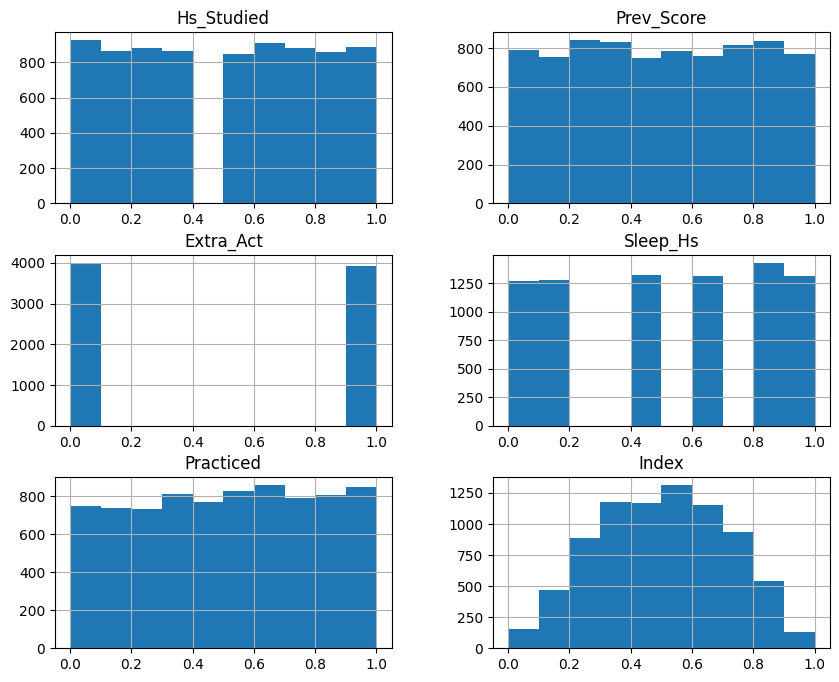

In [182]:
df_train.hist(figsize=(10,8))
plt.show()

### Boxplot Matrix

In [178]:
continuous_features = []
for feat in df_train.columns:
    if df_train[feat].nunique() > 2:
        continuous_features.append(feat)

num_cols = 3
num_rows = (len(continuous_features) + 1) // num_cols
fig = make_subplots(rows=num_rows, cols=num_cols)

for i, feature in enumerate(continuous_features):
    row = i // num_cols + 1
    col = i % num_cols + 1

    fig.add_trace(go.Box(x=df_train[feature], name = ' '), row=row, col=col)

    fig.update_yaxes(title_text = ' ', row=row, col=col)
    fig.update_xaxes(title_text= feature, row=row, col=col)
    fig.update_layout(
        title=f'<b>Boxplot Matrix<br> <sup> Continuous Features</sup></b>',
        showlegend=False, yaxis=dict(tickangle=-90)
    )

fig.update_layout(
    height=200 * num_rows,
    width=800,
    margin=dict(t=50, l=50),
    template= 'simple_white'
)
fig.show()

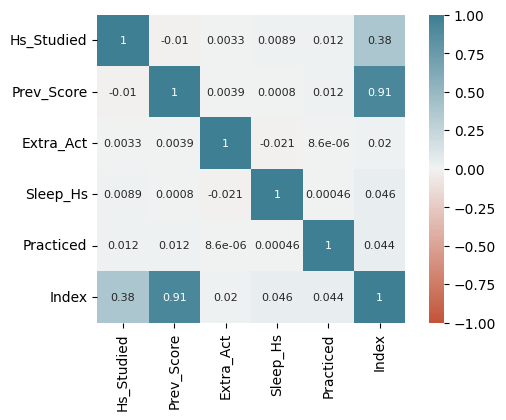

In [154]:
corr = df_train.corr()

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

### Distribuciones

<Figure size 1200x800 with 0 Axes>

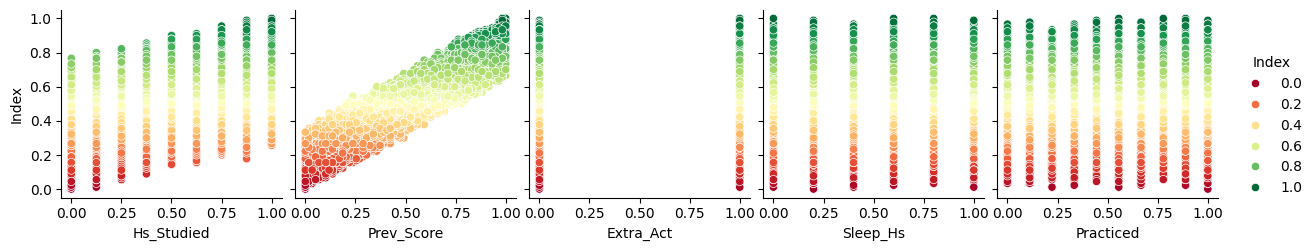

In [190]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_train, hue='Index', x_vars=df_train.drop('Index', axis=1).columns, y_vars='Index', palette='RdYlGn')
plt.show()

# Red Neuronal / Regresión

## Procesamiento en Test

### Pipeline de procesamiento

In [265]:
df_test

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
6252,5,69,No,8,2,51.0
4684,2,46,Yes,4,8,20.0
1731,7,56,Yes,7,5,46.0
4742,6,42,Yes,8,5,28.0
4521,7,53,No,4,6,41.0
...,...,...,...,...,...,...
6412,2,70,No,7,3,45.0
8285,4,79,No,9,3,66.0
7853,2,40,Yes,7,2,16.0
1095,3,83,No,7,5,65.0


In [266]:
df_test = renombrar_columnas(df_test)
df_test = eliminar_registros_duplicados(df_test)
df_test = recategorizar_variables(df_test)
df_test, _ = escalar_datos(df_test, train_scaler_dict)

In [268]:
df_test

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
6252,0.500,0.491525,0.0,0.8,0.222222,0.454545
4684,0.125,0.101695,1.0,0.0,0.888889,0.102273
1731,0.750,0.271186,1.0,0.6,0.555556,0.397727
4742,0.625,0.033898,1.0,0.8,0.555556,0.193182
4521,0.750,0.220339,0.0,0.0,0.666667,0.340909
...,...,...,...,...,...,...
6412,0.125,0.508475,0.0,0.6,0.333333,0.386364
8285,0.375,0.661017,0.0,1.0,0.333333,0.625000
7853,0.125,0.000000,1.0,0.6,0.222222,0.056818
1095,0.250,0.728814,0.0,0.6,0.555556,0.613636


### Conjuntos X e y

In [269]:
X_test, y_test = separar_Xy(df_test, 'Index')

In [270]:
X_test.shape, y_test.shape

((1996, 5), (1996, 1))

## Modelo

### Definición y entrenamiento

In [308]:
# Definición del Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(8, activation='relu'), Dropout(0.1),
    Dense(4, activation='relu'), Dropout(0.1),
    Dense(1, activation='linear')
])

In [309]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8)                 48        
                                                                 
 dropout_16 (Dropout)        (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 4)                 36        
                                                                 
 dropout_17 (Dropout)        (None, 4)                 0         
                                                                 
 dense_26 (Dense)            (None, 1)                 5         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [310]:
# Entrenamiento
print("Inicio del Entrenamiento")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mae'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Inicio del Entrenamiento
Epoch 1/20
199/199 [==============================] - 2s 4ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - mae: 0.2849 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mae: 0.1375
Epoch 2/20
199/199 [==============================] - 1s 3ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - mae: 0.1574 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mae: 0.0919
Epoch 3/20
199/199 [==============================] - 1s 3ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mae: 0.1198 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mae: 0.0779
Epoch 4/20
199/199 [==============================] - 1s 3ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mae: 0.1048 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mae: 0.0714
Epoch 5/20
199/199 [==============================] - 1s 3ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mae: 0.0958 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mae: 0.0718
Epoch

### Visualización de Métricas

In [311]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


Mean Squared Error (MSE): 0.00
R2 Score: 0.95



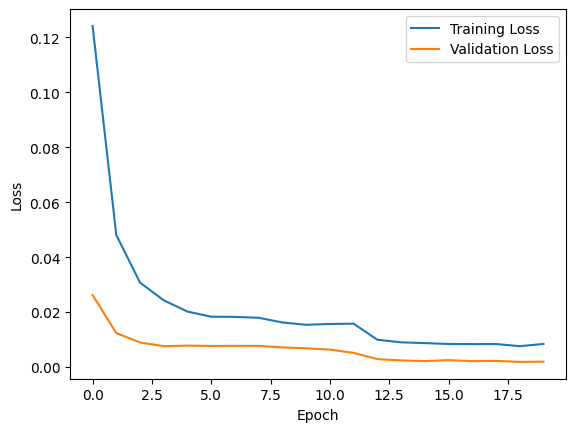

In [312]:
# Métricas de regresión
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("R2 Score: {:.2f}\n".format(r2))

# Graficar la curva de aprendizaje
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicciones

In [314]:
# Crear DataFrame con datos originales
predicciones = pd.DataFrame(df_test, columns=df_test.columns)

# Obtener los scalers para revertir la normalización
for columna in df_test.columns:
    if columna != 'Index' and columna != 'Predicted Index':
        predicciones[columna] = train_scaler_dict[columna].inverse_transform(predicciones[columna].values.reshape(-1, 1))

# Aplicar la transformación inversa solo a las columnas 'Index' y 'Predicted Index'
predicciones['Index'] = y_test
predicciones['Predicted Index'] = y_pred
predicciones[['Index', 'Predicted Index']] = train_scaler_dict['Index'].inverse_transform(predicciones[['Index', 'Predicted Index']])
predicciones['Predicted Index'] = predicciones['Predicted Index'].round(3)  # Redondear a 3 decimales


# Mostrar la tabla de predicciones
predicciones

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index,Predicted Index
6252,5.0,69.0,0.0,8.0,2.0,51.0,54.300
4684,2.0,46.0,1.0,4.0,8.0,20.0,29.590
1731,7.0,56.0,1.0,7.0,5.0,46.0,49.775
4742,6.0,42.0,1.0,8.0,5.0,28.0,36.428
4521,7.0,53.0,0.0,4.0,6.0,41.0,45.622
...,...,...,...,...,...,...,...
6412,2.0,70.0,0.0,7.0,3.0,45.0,48.913
8285,4.0,79.0,0.0,9.0,3.0,66.0,61.589
7853,2.0,40.0,1.0,7.0,2.0,16.0,24.888
1095,3.0,83.0,0.0,7.0,5.0,65.0,61.824


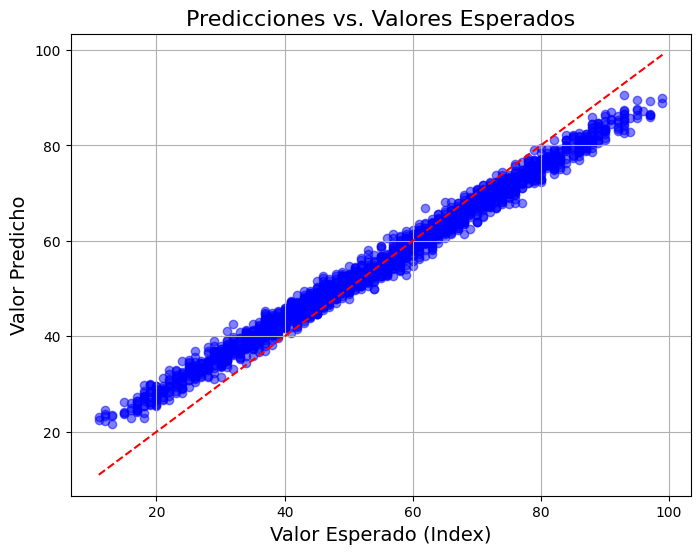

In [318]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(predicciones['Index'], predicciones['Predicted Index'], color='blue', alpha=0.5)  # Scatter plot de los valores esperados vs. predichos
plt.plot([predicciones['Index'].min(), predicciones['Index'].max()], [predicciones['Index'].min(), predicciones['Index'].max()], color='red', linestyle='--')  # Línea diagonal para referencia
plt.title('Predicciones vs. Valores Esperados', fontsize=16)
plt.xlabel('Valor Esperado (Index)', fontsize=14)
plt.ylabel('Valor Predicho', fontsize=14)
plt.grid(True)
plt.show()